# Tarea practica 1 - Norman Daniel Vicente Orellana

In [1]:
import tensorflow as tf
import numpy as np 
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [3]:

data = np.load('proyecto_training_data.npy')

In [4]:
data

array([[2.08500e+05, 7.00000e+00, 8.56000e+02, 8.00000e+00, 2.00300e+03,
        6.50000e+01],
       [1.81500e+05, 6.00000e+00, 1.26200e+03, 6.00000e+00, 1.97600e+03,
        8.00000e+01],
       [2.23500e+05, 7.00000e+00, 9.20000e+02, 6.00000e+00, 2.00100e+03,
        6.80000e+01],
       ...,
       [2.66500e+05, 7.00000e+00, 1.18800e+03, 9.00000e+00, 1.94100e+03,
        6.60000e+01],
       [1.42125e+05, 5.00000e+00, 1.07800e+03, 5.00000e+00, 1.95000e+03,
        6.80000e+01],
       [1.47500e+05, 5.00000e+00, 1.25600e+03, 6.00000e+00, 1.96500e+03,
        7.50000e+01]])

In [5]:
df = pd.DataFrame(data)

In [6]:
df

,0,1,2,3,4,5
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0
...,...,...,...,...,...,...
1455,175000.0,6.0,953.0,7.0,1999.0,62.0
1456,210000.0,6.0,2073.0,7.0,1978.0,85.0
1457,266500.0,7.0,1188.0,9.0,1941.0,66.0
1458,142125.0,5.0,1078.0,5.0,1950.0,68.0


## Training data y test data

In [7]:
index= int(len(data)*0.8)
training_data = data[0: index]
test_data = data[index+1:len(data)]

In [8]:
print('Training data:',training_data.shape)
print('Test data:',test_data.shape)

Training data: (1168, 6)
Test data: (291, 6)


## Variables del modelo

In [9]:
sales_price = training_data[:,0]
total_rooms = training_data[:,3]
x=total_rooms
y=sales_price

## Modelo de Regresion

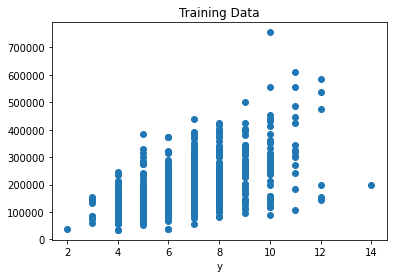

In [10]:
plt.scatter(x, y)
plt.xlabel('x')
plt.xlabel('y')
plt.title("Training Data")
plt.show()

## Definición del grafo

Planteamiento del problema: <br>
<img width=400 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/ln.png?raw=true"></img>

In [12]:
tf.reset_default_graph()
g = tf.Graph()
n = len(x)
with g.as_default():
  tensor_x = tf.placeholder(tf.float32,[None, 1],"tensor_x")
  tensor_y = tf.placeholder(tf.float32,[None, 1],"tensor_y")
  learning_rate = tf.placeholder("float") 

  #Parameters
  with tf.name_scope("parameters"):
    m = tf.get_variable("pendiente",dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
    b = tf.get_variable("intercepto",dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())

  # Hypothesis
  with tf.name_scope("hypothesis"):
   y_pred = tf.add(tf.multiply(m, x), b)
    
  # Mean Squared Error Cost Function
  with tf.name_scope("Error-function"):
    cost = tf.reduce_sum(tf.pow(y_pred-tensor_y, 2)) / (2 * n)
    
    #Cost to Tensorboard  
    cost_summary = tf.summary.scalar("cost", cost)

  with tf.name_scope("Gradient"):

    #Goal: Gradient Descent Optimizer
    optimizer = tf.gradients(cost ,[m,b])  
    actualizacion_m = tf.assign(m, m - learning_rate*optimizer[0] )
    actualizacion_b = tf.assign(b, b - learning_rate*optimizer[1] )
    actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b)

  # Global Variables Initializer
  init = tf.global_variables_initializer()



### Grafo resultante

<img src="https://github.com/normanaspx/Data-Science/blob/master/resources/graph.png?raw=true"/>

### Implementacion de Mini-batch Gradient descent

In [17]:
def linear_model(lr, epochs, batch_size):
  plt.scatter(x,y)
  now = datetime.now()
  total_iteraciones = int(n/batch_size)
  with tf.train.MonitoredSession() as session:
    session = tf.Session(graph = g)
    session.run(init)
    writer = tf.summary.FileWriter("xp/"+str(now)+"n="+str(epochs)+" lr="+str(lr), session.graph)
    for epoch in range(epochs): 
      for i in range(total_iteraciones): 
        muestra_inicio = i*batch_size
        muestra_fin = muestra_inicio + batch_size

        #nuevo arreglo de muestra mas pequena
        x_mb =  np.array(x[muestra_inicio:muestra_fin]).reshape([-1,1])
        y_mb = np.array(y[muestra_inicio:muestra_fin]).reshape([-1,1])
        
        # se envian al grafo
        feed_dict = {tensor_x:x_mb, tensor_y:y_mb, learning_rate:lr}
        session.run(optimizer,feed_dict=feed_dict)
        session.run([actualizacion_parametros,m,b],feed_dict=feed_dict)

      feed_dict = {tensor_x:np.array(x).reshape(-1,1), tensor_y:np.array(y).reshape(-1,1), learning_rate:lr}
      predicciones, cs = session.run([y_pred, cost_summary] ,feed_dict=feed_dict)
      writer.add_summary(cs, epoch+1)

      #Grafica
      plt.plot(x,predicciones,label=str(epoch))

    pendiente, intercepto = session.run([m,b],feed_dict=feed_dict)
    plt.title("Pendiente: m={}  b={}".format(pendiente, intercepto))

#plt.legend()
#plt.show()

## Experimentos


### Modelo lineal con lr=0.001, EPOCHS=100, Batch_size=16

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


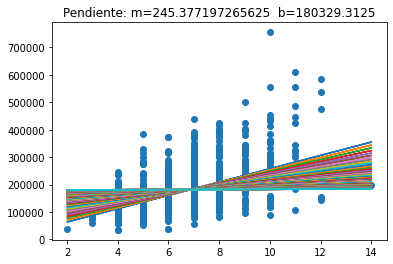

In [18]:
linear_model(0.001, 100, 16)
#tiempo de ejecucion 16 segs

<img width=600 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/m1.PNG?raw=true"></img>

### Modelo lineal con lr=0.001, EPOCHS=150, Batch_size=16

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


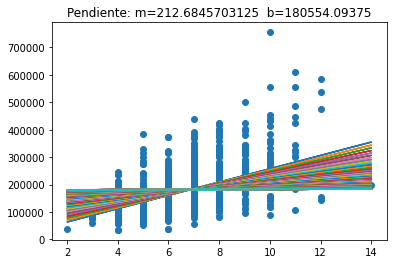

In [ ]:
linear_model(0.001, 150, 16)
#tiempo de ejecucion 25 segs

<img width=600 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/m2.PNG?raw=true"></img>

### Modelo lineal con lr=0.001, EPOCHS=150, Batch_size=8

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


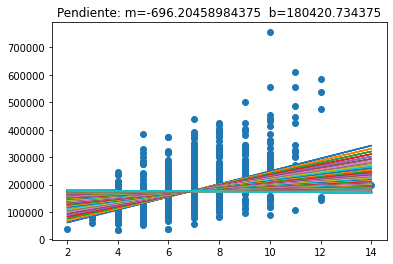

In [ ]:
linear_model(0.001, 150, 8)
#tiempo de ejecucion 38 segs

<img width=600 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/m3.PNG?raw=true"></img>

### Modelo lineal con lr=0.01, EPOCHS=100, Batch_size=8

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


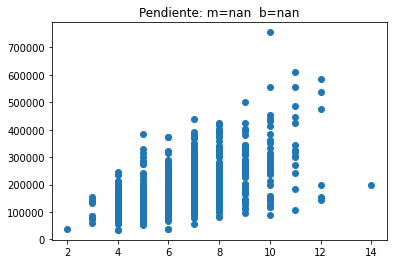

In [ ]:
linear_model(0.01, 150, 8)
#tiempo de ejecucion 18 segs

<img width=600 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/m4.PNG?raw=true"></img>

### Modelo lineal con lr=0.001, EPOCHS=150, Batch_size=32

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


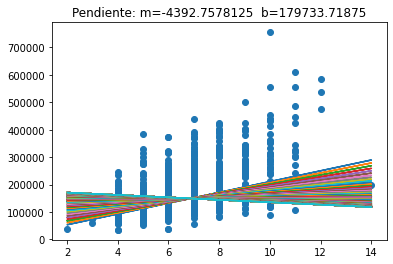

In [ ]:
linear_model(0.001, 150, 32)
#tiempo de ejecucion 18 segs

Curva del modelo: verde <br>
<img width=600 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/m5.PNG?raw=true"></img>

###Modelo lineal con lr=0.0001, EPOCHS=300, Batch_size=32

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


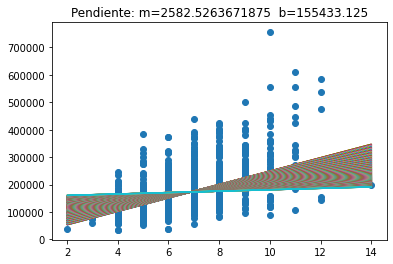

In [ ]:
linear_model(0.0001, 300, 32)
#tiempo de ejecucion 35 segs

Curva del modelo: naranja <br>
<img width=600 heigth=500 src="https://github.com/normanaspx/Data-Science/blob/master/resources/m6.PNG?raw=true"></img>

### Ejecutar tensowboard en colab.research.google.com

In [21]:
#%load_ext tensorboard
#%tensorboard --logdir xp

## Conclusiones

Basado en los resultados de los experimentos se observa que cuando se usa un batch_size alto no minimiza la funcion si le aumentamos los epochs tiende mas a converger.<br> Pero podemos llegar a un mejor minimo y convergercia cuando el batch_size = 16 y batch_size = 8. Cuando usamos estas configuraciones es cuando mas minimiza la funcion.

## Recomendacion

Se comienda usar los hiperparametros: **Learning rate:0.001 EPOCHS: 150 Batch_size:16**